## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA

from typing import List, Callable

## Table of Contents

- [Data Preperation](#data-preperation)
- [Naive Model](#naive-model)
- [AutoRegression Model](#autoregression-model)
- [SARIMAX model](#sarimax-model)

## Data Preperation
Load and split the time series data into train/test sets.

In [2]:
# Loading pickled dataframe
PICKLE_PATH = "../data/apex"
df = pd.read_pickle(PICKLE_PATH)
df = df.set_index(keys="date").resample("H").pad()
df

C:\Users\salim\AppData\Local\Temp\ipykernel_6248\3284831172.py:4: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  df = df.set_index(keys="date").resample("H").pad()


,players,twitch_viewers,date_interval,change_in_players,sma,std,day,hour
date,,,,,,,,
2022-06-03 03:00:00,157067,69159,0 days 00:10:00,1259,NaN,NaN,Fri,3
2022-06-03 04:00:00,159168,77259,0 days 00:10:00,-18,NaN,NaN,Fri,4
2022-06-03 05:00:00,172103,67744,0 days 00:10:00,2704,NaN,NaN,Fri,5
2022-06-03 06:00:00,191923,51578,0 days 00:10:00,2771,NaN,NaN,Fri,6
2022-06-03 07:00:00,204307,47960,0 days 00:10:00,1638,NaN,NaN,Fri,7
...,...,...,...,...,...,...,...,...
2022-06-16 22:00:00,103678,55915,0 days 00:10:00,-1920,173763.516865,3.738793e+09,Thu,22
2022-06-16 23:00:00,97250,55317,0 days 00:10:00,-1084,173756.799603,3.739784e+09,Thu,23
2022-06-17 00:00:00,99135,54288,0 days 00:10:00,422,173748.781746,3.740993e+09,Fri,0


In [3]:
# Setting seaborn figure size
sns.set(rc={'figure.figsize':(11.7,8.27)})

Split the time series into a train and split part since we need a feature that we are predicting for. Unlike the typical random selection of train/test splits we can't do that with time series data. Hence we'll take a specific number of value from the beginning of the time series as the train split and the rest will be our test split.

In [4]:
TRAIN_SIZE = df.players.shape[0] - 30

# Splitting the dataframe into train and test sets
df['train'] = df.players[:TRAIN_SIZE]
df['test'] = df.players[TRAIN_SIZE:]

Text(0.5, 1.0, 'Player Activity Train and Test Sets')

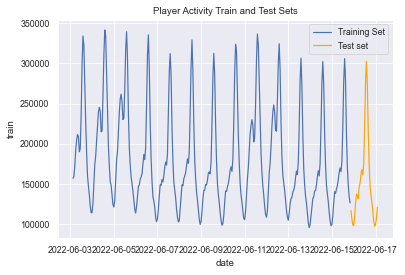

In [5]:
sns.set_theme("paper")
fig = sns.lineplot(data=df.train, label="Training Set")
sns.lineplot(data=df.test, color='orange', label="Test set")

fig.set_title("Player Activity Train and Test Sets")

## Naive Model

When forecasting we will need a baseline to compare the performance of our model which we'll use y<sub>n+1</sub> = y<sub>n</sub> model as our naive base model.

In [6]:
# Predictions using the naive model
preds = np.repeat(df.train.dropna()[-1:], df.shape[0]-TRAIN_SIZE)

# All the predictions stored into the dataframe
#df['naive_pred'] = np.repeat(np.nan, TRAIN_SIZE) + preds
df['naive_pred'] = np.nan
df.iloc[TRAIN_SIZE:,-1:] = preds
df

,players,twitch_viewers,date_interval,change_in_players,sma,std,day,hour,train,test,naive_pred
date,,,,,,,,,,,
2022-06-03 03:00:00,157067,69159,0 days 00:10:00,1259,NaN,NaN,Fri,3,157067.0,NaN,NaN
2022-06-03 04:00:00,159168,77259,0 days 00:10:00,-18,NaN,NaN,Fri,4,159168.0,NaN,NaN
2022-06-03 05:00:00,172103,67744,0 days 00:10:00,2704,NaN,NaN,Fri,5,172103.0,NaN,NaN
2022-06-03 06:00:00,191923,51578,0 days 00:10:00,2771,NaN,NaN,Fri,6,191923.0,NaN,NaN
2022-06-03 07:00:00,204307,47960,0 days 00:10:00,1638,NaN,NaN,Fri,7,204307.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-16 22:00:00,103678,55915,0 days 00:10:00,-1920,173763.516865,3.738793e+09,Thu,22,NaN,103678.0,126297.0
2022-06-16 23:00:00,97250,55317,0 days 00:10:00,-1084,173756.799603,3.739784e+09,Thu,23,NaN,97250.0,126297.0
2022-06-17 00:00:00,99135,54288,0 days 00:10:00,422,173748.781746,3.740993e+09,Fri,0,NaN,99135.0,126297.0


In [7]:
# Computes the root mean square error
rmse = lambda actual, predicated: np.sqrt(mean_squared_error(actual, predicated))

# Computes the mean percentage error and root mean square error for naive model
naive_rmse = rmse(df.test[TRAIN_SIZE:], df.naive_pred[TRAIN_SIZE:]) 
naive_mape = mean_absolute_percentage_error(df.test[TRAIN_SIZE:], df.naive_pred[TRAIN_SIZE:])

The metric `root mean squared error` can be thought of as how wrong the prediction will be off by on average. Not surprisingly the RMSE is 124220 which means that the naive model is going to be off by a large amount.

We decide to use the `mean absolute percentage error` which we can think of as the analogous version of the accuracy metric for classification models. The naive model has a 89% mean absolute percentage error which is quite a lot. One can think of this as essentially having 11% accuracy. 

Text(0.5, 1.0, 'Player Activity Predictation: RMSE: 59839.81, MAPE: 0.22')

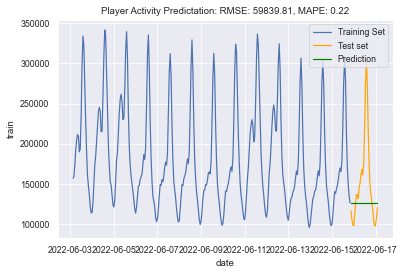

In [8]:
sns.set_theme("paper")
fig = sns.lineplot(data=df.train, label="Training Set")
sns.lineplot(data=df.test, color='orange', label="Test set")
sns.lineplot(data=df.naive_pred, color="green", label="Prediction")

fig.set_title(f"Player Activity Predictation: RMSE: {naive_rmse:.2f}, MAPE: {naive_mape:.2f}")

## Evaluate Model Performance

Implement `cross validation` for time series since we can not randomly choose samples and assign them for test or train sets due to our data being dependent on time. We use a handy function known as `TimeSeriesSplit` from sklearn to handle the splitting of our data.

In [9]:
def naive_model(train: pd.DataFrame, test: pd.DataFrame) -> List[any]:
    """ This is the baseline model to compare the performance of other models. It is a model that assumes
    that the next values of the time series will be whatever the previous value was. (y_n+1 = y_n) 

    Args:
        train (pd.DataFrame): The time series feature that we are interested in prediction.
        test (pd.DataFrame): The test data which we need just for the number of predictions.

    Returns:
        List[any]: Return the prediction as a list.
    """

    return np.repeat(train[-1:], test.shape[0])

In [10]:
def eval_model_perf(df: pd.DataFrame , model: Callable[[pd.DataFrame, pd.DataFrame], List[any]]) -> None:
    """ Evaluates the performance of a model using RMSE and MAPE.

    Args:
        model (_type_): _description_
    """
    rmse_metrics = []
    mape_metrics = []

    tscv = TimeSeriesSplit(n_splits=4)

    for train_index, test_index in tscv.split(df):
        
        cv_train = df.iloc[train_index]
        cv_test = df.iloc[test_index]

        preds = model(cv_train, cv_test)

        rmse_eval = rmse(cv_test, preds) 
        naive_eval = mean_absolute_percentage_error(cv_test, preds)

        rmse_metrics.append(rmse_eval)
        mape_metrics.append(naive_eval)


    print("Cross Validation Results: ")
    print(f"RMSE: {np.mean(rmse_metrics)}")
    print(f"MAPE: {np.mean(mape_metrics)}")

In [11]:
# Evaluating the performance of the naive model using cross validation
eval_model_perf(df.players, naive_model)

    

Cross Validation Results: 
RMSE: 72796.92541950871
MAPE: 0.3584343608656596


## AutoRegression Model

In [12]:
from statsmodels.tsa.ar_model import AutoReg
from pmdarima import auto_arima

model = AutoReg(df.train.dropna(), 3, old_names=False, seasonal=True, period=24)
model = model.fit()

preds = model.predict(start=len(df.train.dropna()), end=len(df.players)-1)
#print(preds)
# All the predictions stored into the dataframe
df['autoreg_pred'] = np.nan
df.iloc[TRAIN_SIZE:,-1:] = preds

Text(0.5, 1.0, 'Apex Player Activity Predictation: RMSE: 17147.87, MAPE: 0.09')

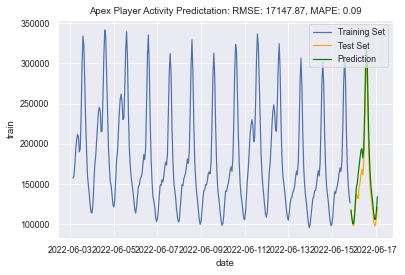

In [13]:
# Computes the mean percentage error and root mean square error for AutoRegression model
autoreg_rmse = rmse(df.test[TRAIN_SIZE:], df.autoreg_pred[TRAIN_SIZE:]) 
autoreg_mape = mean_absolute_percentage_error(df.test[TRAIN_SIZE:], df.autoreg_pred[TRAIN_SIZE:])

fig = sns.lineplot(data=df.train, label="Training Set")
sns.lineplot(data=df.test, color='orange', label="Test Set")
sns.lineplot(data=df.autoreg_pred, color="green", label="Prediction")

fig.set_title(f"Apex Player Activity Predictation: RMSE: {autoreg_rmse:.2f}, MAPE: {autoreg_mape:.2f}")

Cross validation to evaluate the performance of the naive model.

In [29]:
def autoregression_model(train, test):

    # Training the autogression model
    model = AutoReg(train.dropna(), 3, old_names=False, seasonal=True, period=24)
    model = model.fit()

    # Make predictions
    preds = model.predict(start=len(train), end=len(train)+len(test)-1)

    return preds

eval_model_perf(df.players, autoregression_model)




Cross Validation Results: 
RMSE: 25383.095231852454
MAPE: 0.12795825046650805


The autogression model is performing well as our MAPE is 0.127 or in another words about 87.3% accuracy. On average the predictions are off by ~25000. This suggests that the first initial train/test evaluation was better than most train/test splits. This is why we do cross validation to make sure that our train/test does happen to give us good evaluations for our metrics by chance. 

## ARIMA Model

One approach to time series forecasting is using `ARIMA models`. This type of model aims to describe the autocorrelations in the data. Similar to a multiple linear regression model where we use a linear combination of predictors but instead we use linear combination of the past values.

In [14]:
# Check for stationarity of the data before trying the ARIMA model
from pmdarima.arima import ndiffs
kpss_diff = ndiffs(df.players.values, alpha=0.05, test='kpss', max_d=12)
adf_diff = ndiffs(df.players.values, alpha=0.05, test='adf', max_d=12)
n_diffs = max(adf_diff , kpss_diff )

print((kpss_diff, adf_diff, n_diffs))

(0, 0, 0)


C:\Users\salim\Desktop\Data-Science-Machine-Learning-Portfolio\Steam Charts\env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


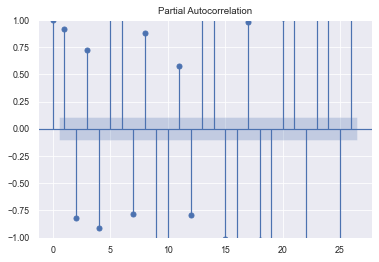

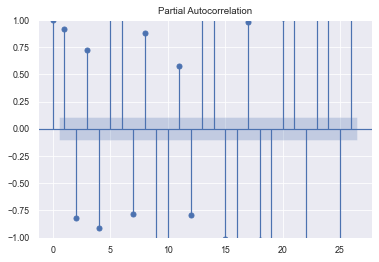

In [15]:
# Determining seasonal order
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller

plot_pacf(df.players)



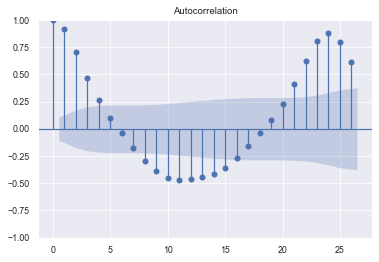

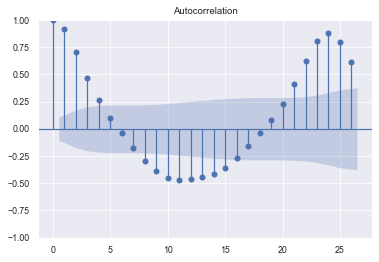

In [16]:
plot_acf(df.players)

In [17]:
## ARIMA Model: Determine AR model
import warnings
warnings.filterwarnings("ignore")

model = auto_arima(df.train.dropna(), trace=True, surpress_warnings=True)
model.summary()


#print(res.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=6605.446, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=7632.139, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7081.760, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7416.512, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8317.792, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=6653.103, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=6663.191, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=6595.454, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=6603.427, Time=0.10 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=6592.990, Time=0.19 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=6600.036, Time=0.16 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=6574.872, Time=0.26 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=6558.982, Time=0.62 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  306
Model:               SARIMAX(5, 0, 4)   Log Likelihood               -3261.733
Date:                Thu, 23 Jun 2022   AIC                           6545.466
Time:                        23:27:06   BIC                           6586.426
Sample:                             0   HQIC                          6561.847
                                - 306                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.027e+04   1.83e+04      1.650      0.099   -5692.074    6.62e+04
ar.L1          0.8334      0.082     10.113      0.000       0.672       0.995
ar.L2         -0.5245      0.061     -8.610      0.000      -0.644      -0.405
ar.L3          0.9217      0.040     22.973      0.000       0.843       1.000
ar.L4         -0.8561      0.073    -11.782      0.000      -0.999      -0.714
ar.L5          0.4583      0.069      6.625      0.000       0.323       0.594
ma.L1          1.6848      0.088     19.197      0.000       1.513       1.857
ma.L2          2.2132      0.148     14.917      0.000       1.922       2.504
ma.L3          1.2630      0.146      8.625      0.000       0.976       1.550
ma.L4          0.5400      0.081      6.699      0.000       0.382       0.698
sigma2      1.094e+08     10.046   1.09e+07      0.000    1.09e+08    1.09e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                16.92
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.50
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.9e+21. Standard errors may be unstable.
"""

In [18]:
model = ARIMA(df.train.values, order=(5,0,4), seasonal_order=(0,0,0,0)).fit()
#model = model.fit()
preds = model.predict(start=len(df.train.dropna()), end=len(df.players)-1, typ='levels')
#print(preds)

df['arima_pred'] = np.nan
df.iloc[TRAIN_SIZE:,-1:] = preds

def arima_model(train: pd.DataFrame, test: pd.DataFrame, order: tuple = (2, 1, 2)) -> List[any]:
    """ Trains an autoregression model to forecast future time series values.

    Args:
        train (pd.DataFrame): _description_
        test (pd.DataFrame): _description_

    Returns:
        List[any]: _description_
    """


    arma = ARIMA(train, (2,2)).fit(disp=False)
    preds = arma.predict(test)

    return preds



In [19]:
# print(preds)

# All the predictions stored into the dataframe
#df['naive_pred'] = np.repeat(np.nan, TRAIN_SIZE) + preds
df['arima_pred'] = np.nan
df.iloc[TRAIN_SIZE:,-1:] = preds

Text(0.5, 1.0, 'Player Activity Predictation: RMSE: 59590.36, MAPE: 0.39')

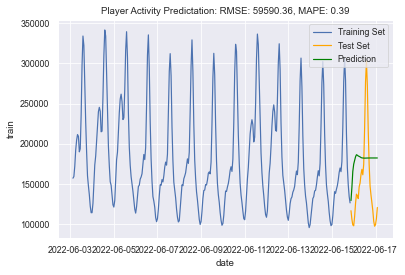

In [20]:
# Computes the mean percentage error and root mean square error for arima model
arima_rmse = rmse(df.test[TRAIN_SIZE:], df.arima_pred[TRAIN_SIZE:]) 
arima_mape = mean_absolute_percentage_error(df.test[TRAIN_SIZE:], df.arima_pred[TRAIN_SIZE:])

fig = sns.lineplot(data=df.train, label="Training Set")
sns.lineplot(data=df.test, color='orange', label="Test Set")
sns.lineplot(data=df.arima_pred, color="green", label="Prediction")

fig.set_title(f"Player Activity Predictation: RMSE: {arima_rmse:.2f}, MAPE: {arima_mape:.2f}")

## FB Prophet Model

One of the advantages of the FB Prophet model is that the model provides and upper and lower bound for the prediction.

In [22]:
from prophet import Prophet

m = Prophet()
m.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=24)
m.predict(future)


In [ ]:
# Create fb prophet model



## LSTM Model